In [3]:
class AlexRipOff:
    
    def __init__(self,number_of_classes,image_height,image_width,train_dataset_path,valid_dataset_path,model_path,epochs,data_loader_batch_size):
    
        self.mood                   = "Have fun"
        self.number_of_classes      = number_of_classes
        self.image_height           = image_height
        self.image_width            = image_width
        self.train_dataset_path     = train_dataset_path
        self.valid_dataset_path     = valid_dataset_path
        self.model_path             = model_path
        self.epochs                 = epochs
        self.data_loader_batch_size = data_loader_batch_size
        self.model                  = Sequential()

   
    def add_conv_layer(self, outputs, kernel_size, strides, padding, activation, kernel_initializer,*input_shape):
     
        try:
   
            self.model.add(
                       Conv2D(filters     = outputs, 
                       kernel_size        = kernel_size,
                       strides            = strides,
                       padding            = padding,
                       activation         = activation,
                       input_shape        = input_shape[0],
                       kernel_initializer = kernel_initializer))
        except:
            
            
            self.model.add(
                       Conv2D(filters            = outputs, 
                       kernel_size        = kernel_size,
                       strides            = strides,
                       padding            = padding,
                       activation         = activation,
                       kernel_initializer = kernel_initializer))
    
    def add_max_pooling_layer(self, pool_size, strides, padding ,data_format):
    
        return self.model.add(
                    MaxPooling2D(pool_size   = pool_size,
                                 strides     = strides,
                                 padding     = padding, 
                                 data_format = None))

    def add_dense_layer(self, units, activation):
        
        return self.model.add(
                    Dense(units      = units , 
                          activation = activation ))
    
    def add_flatten_layer(self):
        
        return self.model.add(Flatten())
    
    def compile_model(self, optimizer, loss, metrics):
        
        return self.model.compile(optimizer= optimizer,
                            loss= loss,
                            metrics = metrics)
    
    def construct_model(self):
        
        self.add_conv_layer(96, (11,11), 4, 'valid', 'relu','he_normal', (self.image_height, self.image_width, 3) )

        self.add_max_pooling_layer( (3,3), (2,2), 'valid' ,None)
        
        self.add_conv_layer(256, (5,5), 1, 'same', 'relu','he_normal')
        
        self.add_max_pooling_layer( (3,3), (2,2), 'valid' ,None)
        
        self.add_conv_layer(384, (3,3), 1, 'same', 'relu','he_normal')
        
        self.add_conv_layer(384, (3,3), 1, 'same', 'relu','he_normal')
        
        self.add_conv_layer(256, (3,3), 1, 'same', 'relu','he_normal')
        
        self.add_max_pooling_layer( (3,3), (2,2), 'valid' ,None)
        
        self.add_flatten_layer()
        
        self.add_dense_layer(4096, 'relu')
        
        self.add_dense_layer(4096, 'relu')
        
        self.add_dense_layer(1000, 'relu')
        
        self.add_dense_layer(self.number_of_classes, 'softmax')

        self.compile_model(tf.keras.optimizers.Adam(0.001), 'categorical_crossentropy', ['accuracy'])
        
    
    def image_loaders(self,type_of_data):
        
        if type_of_data == "train":
        
            data_generator = ImageDataGenerator(rescale            = 1./255,
                                                rotation_range     = 10,
                                                width_shift_range  = 0.1,
                                                height_shift_range = 0.1,
                                                shear_range        = 0.1,
                                                zoom_range         = 0.1)

            data_loader = data_generator.flow_from_directory(self.train_dataset_path,
                                                    target_size = (self.image_height, self.image_width),
                                                    color_mode  = "rgb",
                                                    batch_size  = self.data_loader_batch_size,
                                                    seed        = 1,
                                                    shuffle     = True,
                                                    class_mode  = "categorical")
            return data_loader
        
        elif type_of_data == "validation":
        
            data_generator = ImageDataGenerator(rescale = 1./255)

            data_loader = data_generator.flow_from_directory(self.valid_dataset_path,
                                                    target_size = (self.image_height, self.image_width),
                                                    color_mode  = "rgb",
                                                    batch_size  = self.data_loader_batch_size,
                                                    seed        = 1,
                                                    shuffle     = True,
                                                    class_mode  = "categorical")
            return data_loader
        
        
    def train_model(self):
        
        train_loader = self.image_loaders("train")
        train_number = train_loader.samples
    
        valid_loader = self.image_loaders("validation")
        valid_number = valid_loader.samples


        
    
        model_report = self.model.fit(train_loader,
                                      epochs           = self.epochs,
#                                       steps_per_epoch  = train_number,
                                      validation_data  = valid_loader,
#                                       validation_steps = valid_number,
#                                       callbacks=callback_list,
                                      verbose          = 2)
        print(self.model.summary())
        
        self.plot_accuracy(model_report)
        self.plot_loss(model_report)
        
        self.model.save(model_path)

        
    def plot_accuracy(self,hist):
        
        plt.plot(hist.history["accuracy"])
        plt.plot(hist.history["val_accuracy"])
        plt.title("Model accuracy")
        plt.ylabel("accuracy")
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()
 
    def plot_loss(self,hist):
        
        plt.plot(hist.history["loss"])
        plt.plot(hist.history["val_loss"])
        plt.title("Model loss")
        plt.ylabel("loss")
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()
        
    def random_image_check(self):
        
        class_names = os.listdir('small_folder')


        valid_loader = self.image_loaders("validation")

        x_valid, label_batch  = next(iter(valid_loader))

        prediction_values = self.model.predict_classes(x_valid)
        
        fig = plt.figure(figsize=(10, 6))
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
        for i in range(8):
            ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
            ax.imshow(x_valid[i,:],cmap=plt.cm.gray_r, interpolation='nearest')

            if prediction_values[i] == np.argmax(label_batch[i]):
                ax.text(3, 17, class_names[prediction_values[i]], color='blue', fontsize=14)
            else:
                ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)


        

Found 5470 images belonging to 5 classes.
Found 600 images belonging to 5 classes.
Epoch 1/30


2022-12-05 22:05:47.338090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-05 22:06:29.941387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


171/171 - 44s - loss: 3.6648 - accuracy: 0.2503 - val_loss: 1.4458 - val_accuracy: 0.3200
Epoch 2/30
171/171 - 44s - loss: 1.4490 - accuracy: 0.3402 - val_loss: 1.3115 - val_accuracy: 0.4183
Epoch 3/30
171/171 - 44s - loss: 1.2952 - accuracy: 0.4660 - val_loss: 1.1906 - val_accuracy: 0.5333
Epoch 4/30
171/171 - 44s - loss: 1.1366 - accuracy: 0.5351 - val_loss: 0.9689 - val_accuracy: 0.6150
Epoch 5/30
171/171 - 44s - loss: 1.0441 - accuracy: 0.5912 - val_loss: 0.9018 - val_accuracy: 0.6517
Epoch 6/30
171/171 - 44s - loss: 0.9239 - accuracy: 0.6431 - val_loss: 0.7768 - val_accuracy: 0.7050
Epoch 7/30
171/171 - 44s - loss: 0.8540 - accuracy: 0.6718 - val_loss: 0.7215 - val_accuracy: 0.7317
Epoch 8/30
171/171 - 44s - loss: 0.8261 - accuracy: 0.6899 - val_loss: 0.7873 - val_accuracy: 0.7167
Epoch 9/30
171/171 - 44s - loss: 0.7894 - accuracy: 0.7079 - val_loss: 0.7069 - val_accuracy: 0.7583
Epoch 10/30
171/171 - 44s - loss: 0.7614 - accuracy: 0.7210 - val_loss: 0.6805 - val_accuracy: 0.7533


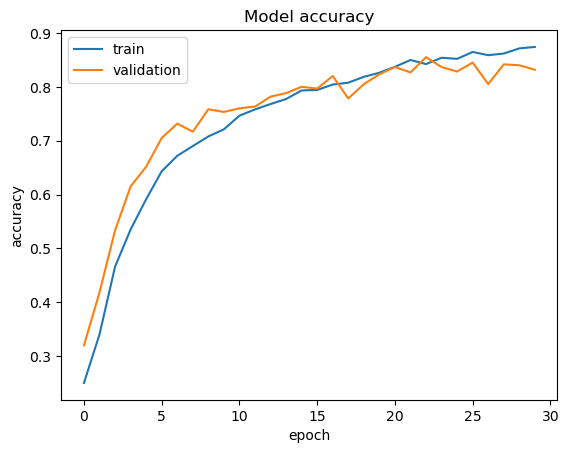

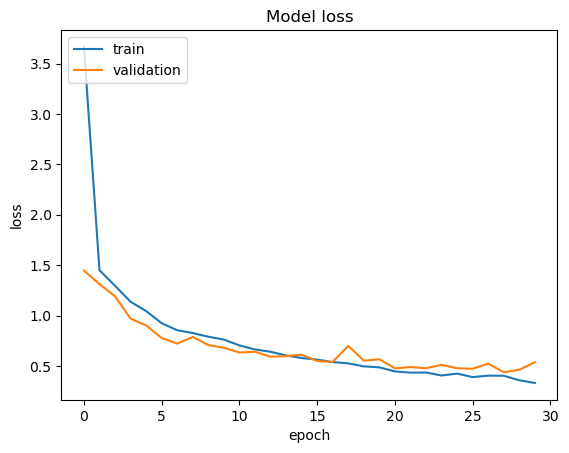

TypeError: Inputs to a layer should be tensors. Got: ./alex_rip_off.h5

In [4]:
if __name__ == "__main__": 
    
    import datetime
    import numpy as np
    import os
    import tensorflow as tf
    import matplotlib.pyplot as plt
    
    from tensorflow.keras import Model
    from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
    from tensorflow.keras.losses import categorical_crossentropy
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.utils import to_categorical

    
    epochs                 = 30
    data_loader_batch_size = 32
    image_height           = 227
    image_width            = 227
    train_dataset_path     = "small_folder"
    valid_dataset_path     = "test"
    model_path             = "./alex_rip_off.h5"
    number_of_classes      = 5 
    
    
    alex_rip_off_model = AlexRipOff(number_of_classes,image_height,image_width,train_dataset_path,valid_dataset_path,model_path,epochs,data_loader_batch_size)
    
    alex_rip_off_model.construct_model()
    
    alex_rip_off_model.train_model()
    
    alex_rip_off_model.random_image_check()
    
    
    print("Model is Run")


